# Adversarial Autoencoder


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# random seed for reproducibility
torch.manual_seed(42)

# Model Implementation

In [3]:
# Encoder network
class Encoder(nn.Module):
    def __init__(self, input_dim=768, latent_dim=256):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 384)
        self.bn2 = nn.BatchNorm1d(384)

        self.fc3 = nn.Linear(384, latent_dim)

    def forward(self, x):
        h = F.leaky_relu(self.bn1(self.fc1(x)), 0.2)
        h = F.leaky_relu(self.bn2(self.fc2(h)), 0.2)
        latent = self.fc3(h)
        return latent

In [4]:
# Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim=256, output_dim=768):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 384)
        self.bn1 = nn.BatchNorm1d(384)

        self.fc2 = nn.Linear(384, 512)
        self.bn2 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, z):
        h = F.leaky_relu(self.bn1(self.fc1(z)), 0.2)
        h = F.leaky_relu(self.bn2(self.fc2(h)), 0.2)
        reconstructed = torch.sigmoid(self.fc3(h))
        return reconstructed

In [5]:
class Discriminator(nn.Module):
    def __init__(self, latent_dim=256):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 1)

    def forward(self, z):
        h = F.leaky_relu(self.bn1(self.fc1(z)), 0.2)
        h = F.leaky_relu(self.bn2(self.fc2(h)), 0.2)
        logits = self.fc3(h)
        return logits

In [6]:
# Define the full Adversarial Autoencoder
class AdversarialAutoencoder:
    def __init__(self, input_dim=768, latent_dim=256, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.device = device

        # Initialize networks
        self.encoder = Encoder(input_dim, latent_dim).to(device)
        self.decoder = Decoder(latent_dim, input_dim).to(device)
        self.discriminator = Discriminator(latent_dim).to(device)

        # Initialize optimizers
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0001)

        # Loss functions
        self.reconstruction_loss = nn.MSELoss()
        self.adversarial_loss = nn.BCEWithLogitsLoss()

    def train_step(self, x_batch):
        batch_size = x_batch.size(0)
        x_batch = x_batch.to(self.device)

        # Target tensors
        real_target = torch.ones(batch_size, 1).to(self.device)
        fake_target = torch.zeros(batch_size, 1).to(self.device)

        # Train Autoencoder
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # Encode and decode the input
        z = self.encoder(x_batch)
        x_reconstructed = self.decoder(z)

        # Compute reconstruction loss
        recon_loss = self.reconstruction_loss(x_reconstructed, x_batch)

        # Compute adversarial loss for the generator (encoder)
        gen_loss = self.adversarial_loss(self.discriminator(z), real_target)

        # Total autoencoder loss
        ae_loss = recon_loss + gen_loss

        # Backpropagate and update parameters
        ae_loss.backward()
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # Train Discriminator
        self.discriminator_optimizer.zero_grad()

        # Generate latent vectors from the prior distribution (Gaussian in this case)
        z_prior = torch.randn(batch_size, self.latent_dim).to(self.device)

        # Get encoded samples
        z_encoded = self.encoder(x_batch).detach()  # Detach to avoid training the encoder again

        # Compute discriminator loss
        real_loss = self.adversarial_loss(self.discriminator(z_prior), real_target)
        fake_loss = self.adversarial_loss(self.discriminator(z_encoded), fake_target)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagate and update parameters
        d_loss.backward()
        self.discriminator_optimizer.step()

        return {
            'reconstruction_loss': recon_loss.item(),
            'generator_loss': gen_loss.item(),
            'discriminator_loss': d_loss.item()
        }

    def train(self, data_loader, epochs=100):
        self.encoder.train()
        self.decoder.train()
        self.discriminator.train()

        training_history = []

        for epoch in range(epochs):
            epoch_losses = {'reconstruction_loss': 0, 'generator_loss': 0, 'discriminator_loss': 0}
            batch_count = 0

            for batch_idx, (x_batch, _) in enumerate(data_loader):
                step_losses = self.train_step(x_batch)

                for key in epoch_losses:
                    epoch_losses[key] += step_losses[key]
                batch_count += 1

            # Calculate average losses for the epoch
            for key in epoch_losses:
                epoch_losses[key] /= batch_count

            training_history.append(epoch_losses)

            print(f"Epoch [{epoch+1}/{epochs}] - "
                  f"Recon Loss: {epoch_losses['reconstruction_loss']:.4f}, "
                  f"Gen Loss: {epoch_losses['generator_loss']:.4f}, "
                  f"Disc Loss: {epoch_losses['discriminator_loss']:.4f}")

        return training_history

    def encode(self, x):
        self.encoder.eval()
        with torch.no_grad():
            x = x.to(self.device)
            z = self.encoder(x)
        return z

    def decode(self, z):
        self.decoder.eval()
        with torch.no_grad():
            z = z.to(self.device)
            x_reconstructed = self.decoder(z)
        return x_reconstructed

    def reconstruct(self, x):
        self.encoder.eval()
        self.decoder.eval()
        with torch.no_grad():
            x = x.to(self.device)
            z = self.encoder(x)
            x_reconstructed = self.decoder(z)
        return x_reconstructed

    def save_model(self, path):
        torch.save({
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict()
        }, path)

    def load_model(self, path):
        checkpoint = torch.load(path,  weights_only=True)
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])


# Utlity Functions

In [7]:
def split_data(combined_embeddings, combined_labels, train_ratio=0.9):
    # Calculate the number of samples for each set
    n_samples = combined_embeddings.shape[0]
    train_size = int(train_ratio * n_samples)
    test_size = n_samples - train_size
    
    # Create the full dataset
    full_dataset = TensorDataset(combined_embeddings, combined_labels)
    
    # Split the dataset
    train_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    print(f"Train set: {train_size} samples")
    print(f"Test set: {test_size} samples")
    
    return train_loader, test_loader

In [8]:
def train_with_validation(model, train_loader, test_loader, epochs=100, save_dir='./models'):
    os.makedirs(save_dir, exist_ok=True)
    
    model.encoder.train()
    model.decoder.train()
    model.discriminator.train()
    
    training_history = []
    test_history = []
    best_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        epoch_losses = {'reconstruction_loss': 0, 'generator_loss': 0, 'discriminator_loss': 0}
        batch_count = 0
        
        for batch_idx, (x_batch, _) in enumerate(train_loader):
            step_losses = model.train_step(x_batch)
            
            for key in epoch_losses:
                epoch_losses[key] += step_losses[key]
            batch_count += 1
        
        # Calculate average losses for the epoch
        for key in epoch_losses:
            epoch_losses[key] /= batch_count
        
        training_history.append(epoch_losses)
        
        # Evaluation on test set
        test_loss = evaluate_model(model, test_loader)
        test_history.append(test_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Recon Loss: {epoch_losses['reconstruction_loss']:.4f}, "
              f"Gen Loss: {epoch_losses['generator_loss']:.4f}, "
              f"Disc Loss: {epoch_losses['discriminator_loss']:.4f}, "
              f"Test Recon Loss: {test_loss['reconstruction_loss']:.4f}")
        
        # Save the best model
        if test_loss['reconstruction_loss'] < best_loss:
            best_loss = test_loss['reconstruction_loss']
            model.save_model(os.path.join(save_dir, 'best_aae_model.pt'))
            print(f"Model saved with validation loss: {best_loss:.4f}")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            model.save_model(os.path.join(save_dir, f'aae_model_epoch_{epoch+1}.pt'))
    
    # Save the final model
    model.save_model(os.path.join(save_dir, 'final_aae_model.pt'))
    
    return training_history, test_history

In [9]:
def evaluate_model(model, test_loader):
    model.encoder.eval()
    model.decoder.eval()
    
    total_recon_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x_batch, _ in test_loader:
            x_batch = x_batch.to(model.device)
            reconstructed = model.reconstruct(x_batch)
            
            # Calculate reconstruction loss
            loss = model.reconstruction_loss(reconstructed, x_batch)
            
            total_recon_loss += loss.item() * x_batch.size(0)
            total_samples += x_batch.size(0)
    
    avg_recon_loss = total_recon_loss / total_samples
    return {
        'reconstruction_loss': avg_recon_loss
    }

In [10]:
def plot_training_history(training_history):
    epochs = range(1, len(training_history) + 1)
    
    plt.figure(figsize=(12, 8))
    
    # Plot reconstruction loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, [epoch_loss['reconstruction_loss'] for epoch_loss in training_history], 'b-')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Plot generator loss
    plt.subplot(3, 1, 2)
    plt.plot(epochs, [epoch_loss['generator_loss'] for epoch_loss in training_history], 'g-')
    plt.title('Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Plot discriminator loss
    plt.subplot(3, 1, 3)
    plt.plot(epochs, [epoch_loss['discriminator_loss'] for epoch_loss in training_history], 'r-')
    plt.title('Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.savefig('aae_training_history.png')
    plt.show()


In [11]:
def plot_train_vs_test_loss(training_history, test_history):
    epochs = range(1, len(training_history) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, [epoch_loss['reconstruction_loss'] for epoch_loss in training_history], 'b-', label='Training Loss')
    plt.plot(epochs, [epoch_loss['reconstruction_loss'] for epoch_loss in test_history], 'r-', label='Validation Loss')
    plt.title('Training vs Validation Reconstruction Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('train_vs_test_loss.png')
    plt.show()

In [12]:
root = "/kaggle/input/recommendation-embeddings-inputs"

In [13]:
movies_df = pd.read_parquet(os.path.join(root, 'movies_embeddings.parquet'), engine='pyarrow')
songs_df = pd.read_parquet(os.path.join(root, 'song_embeddings.parquet'), engine='pyarrow')


In [14]:
movies_df.head()

,id,title,overview,genres,embedding
0,27205,Inception,Cobb a skilled thief who commits corporate esp...,"Action, Science Fiction, Adventure","[0.01589059643447399, 0.11273891478776932, -0...."
1,157336,Interstellar,The adventures of a group of explorers who mak...,"Adventure, Drama, Science Fiction","[0.037922028452157974, -0.005655079614371061, ..."
2,155,The Dark Knight,Batman raises the stakes in his war on crime W...,"Drama, Action, Crime, Thriller","[0.011266704648733139, 0.032755907624959946, -..."
3,19995,Avatar,In the 22nd century a paraplegic Marine is dis...,"Action, Adventure, Fantasy, Science Fiction","[0.01744804158806801, 0.03436880186200142, 0.0..."
4,24428,The Avengers,When an unexpected enemy emerges and threatens...,"Science Fiction, Action, Adventure","[0.027801260352134705, -0.019952325150370598, ..."


In [15]:
songs_df.head()

,title,tag,lyrics,embedding
0,Poor Poor Pitiful Me,country,Well I lay my head on the railroad track\nWait...,"[0.029062896966934204, 0.08223594725131989, -0..."
1,Cuckoos Nest,country,There is a thorn bush\nIn Outcolia\nThere is a...,"[0.0009067401406355202, -0.09515126794576645, ..."
2,Wedding Bells,country,I have the invitation that your sent me\nYou w...,"[0.04617173597216606, 0.013956493698060513, -0..."
3,Could Have Fooled Me,country,Im fading like the taillights\nOf a car that y...,"[0.015817370265722275, -0.0025993576273322105,..."
4,Shot of Glory,country,Its finally payday\nMeeting the boys at my pla...,"[-0.011555955745279789, 0.0511910654604435, 0...."


In [16]:
#'label' column to movies_df with value 1
movies_df['label'] = 1

# 'label' column to songs_df with value 0
songs_df['label'] = 0

# Keep only the 'embedding' and 'label' columns
movies_df = movies_df[['embedding', 'label']]
songs_df = songs_df[['embedding', 'label']]


In [17]:
# Vertically stack (concatenate) the two DataFrames
combined_data = pd.concat([movies_df, songs_df], axis=0, ignore_index=True)

# Shuffle the combined DataFrame
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract combined embeddings and labels
# Assuming that the embedding column stores a list of numbers for each row.
combined_embeddings = np.array(combined_data['embedding'].tolist())
combined_labels = np.array(combined_data['label'].tolist())

combined_embeddings.shape, combined_labels.shape

((1130862, 768), (1130862,))

In [18]:
combined_embeddings = torch.tensor(combined_embeddings, dtype=torch.float32)
combined_labels = torch.tensor(combined_labels, dtype=torch.float32)

combined_dataset = TensorDataset(combined_embeddings, combined_labels)
combined_dataloader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

In [19]:
train_loader, test_loader = split_data(combined_embeddings, combined_labels)

Train set: 1017775 samples
Test set: 113087 samples


In [20]:
# free up memory
del movies_df, songs_df, combined_data, combined_embeddings, combined_labels

In [21]:
input_dim = 768
latent_dim = 256

# Our embedding data is normalized 

aae = AdversarialAutoencoder(input_dim, latent_dim)
training_history, test_history = train_with_validation(aae, train_loader, test_loader, epochs=20)

# training_history = aae.train(combined_dataloader, epochs=2)

Epoch [1/20] - Train Recon Loss: 0.0012, Gen Loss: 0.6911, Disc Loss: 0.6951, Test Recon Loss: 0.0010
Model saved with validation loss: 0.0010
Epoch [2/20] - Train Recon Loss: 0.0010, Gen Loss: 0.6933, Disc Loss: 0.6932, Test Recon Loss: 0.0010
Model saved with validation loss: 0.0010
Epoch [3/20] - Train Recon Loss: 0.0009, Gen Loss: 0.6933, Disc Loss: 0.6932, Test Recon Loss: 0.0009
Model saved with validation loss: 0.0009
Epoch [4/20] - Train Recon Loss: 0.0009, Gen Loss: 0.6932, Disc Loss: 0.6932, Test Recon Loss: 0.0009
Model saved with validation loss: 0.0009
Epoch [5/20] - Train Recon Loss: 0.0009, Gen Loss: 0.6932, Disc Loss: 0.6932, Test Recon Loss: 0.0009
Model saved with validation loss: 0.0009
Epoch [6/20] - Train Recon Loss: 0.0009, Gen Loss: 0.6933, Disc Loss: 0.6932, Test Recon Loss: 0.0009
Model saved with validation loss: 0.0009
Epoch [7/20] - Train Recon Loss: 0.0009, Gen Loss: 0.6933, Disc Loss: 0.6931, Test Recon Loss: 0.0009
Model saved with validation loss: 0.0009

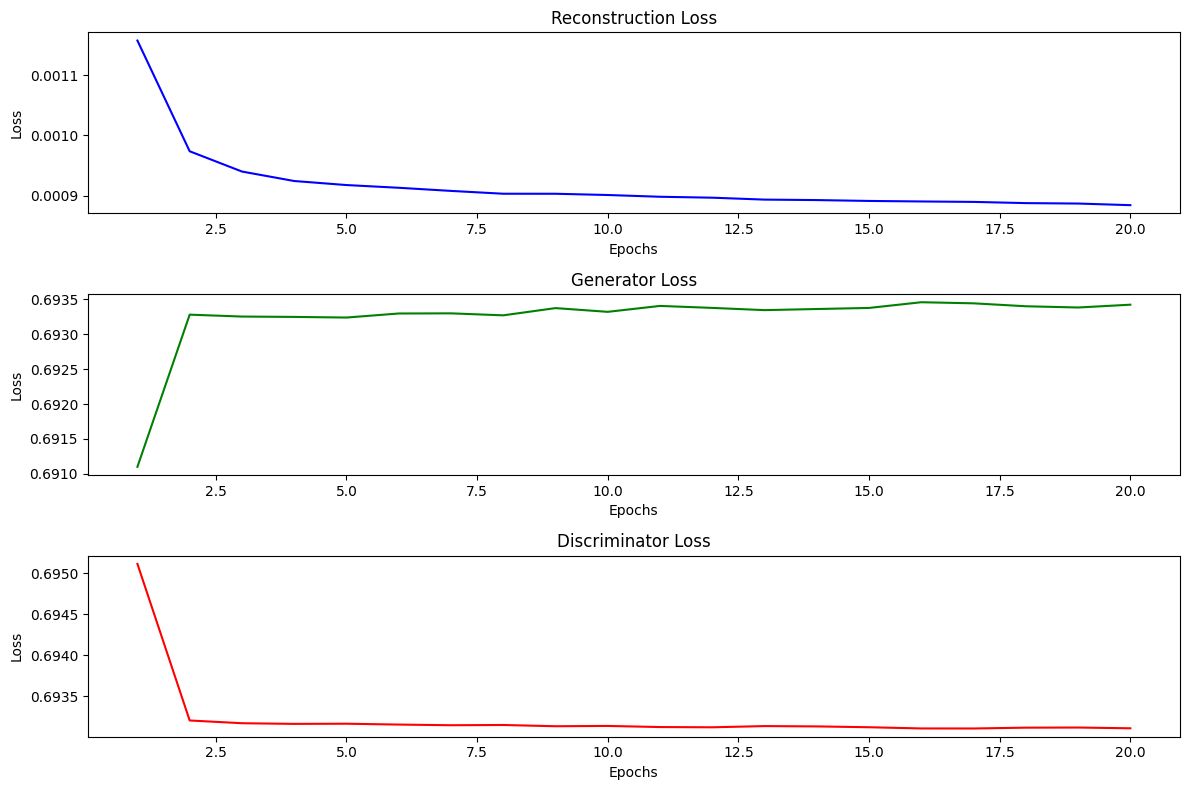

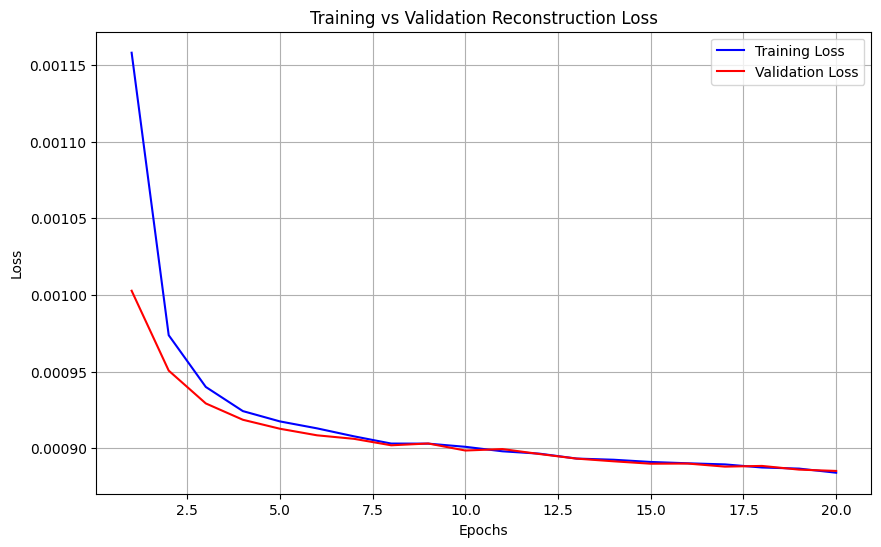

In [22]:
# Visualize the training history
plot_training_history(training_history)
plot_train_vs_test_loss(training_history, test_history)

In [23]:
# Load the best model for inference
best_model_path = './models/best_aae_model.pt'
inference_aae = AdversarialAutoencoder(input_dim=768, latent_dim=256)
inference_aae.load_model(best_model_path)

In [24]:
# Test the model on a few samples
test_samples = next(iter(test_loader))[0][:5]
reconstructed_samples = inference_aae.reconstruct(test_samples)

# Calculate reconstruction error
reconstruction_error = mean_squared_error(
    test_samples.cpu().numpy().flatten(), 
    reconstructed_samples.cpu().numpy().flatten()
)
print(f"Reconstruction MSE on test samples: {reconstruction_error:.4f}")

Reconstruction MSE on test samples: 0.0009


In [25]:
# Generate new samples from random latent vectors
random_latent = torch.randn(5, latent_dim).to(inference_aae.device)
generated_samples = inference_aae.decode(random_latent)
print("Generated samples shape:", generated_samples.shape)

Generated samples shape: torch.Size([5, 768])
